In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/Arra1807/Inform_project_new.git

fatal: destination path 'Inform_project_new' already exists and is not an empty directory.


In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Load Data

In [4]:
import numpy as np
from Inform_project_new.data.echosounder_data.load_data.get_echograms_2 import get_echograms, count_classes_in_echograms

# You can select a specific year or use 'all' to include multiple years.
years = 2014
minimum_shape = 224
tuple_frequencies = (18, 38, 70, 120, 200, 333)
echograms = get_echograms(years=years, tuple_frequencies=tuple_frequencies, minimum_shape=minimum_shape)
print(f"Number of echograms: {len(echograms)}")


Selected 10 echograms from year 2014
Number of echograms: 10


# Split Large Echograms into Train images and Test images

In [ ]:
import os
import random
# Randomly split echograms into train/test
random.seed(42)  # Set a seed for reproducibility
Train_eg = []
test_eg = []
echogram = random.shuffle(echograms)  # Shuffle echograms randomly
for i,echogram in enumerate(echograms):
  if i < 0.8*len(echograms):
    Train_eg.append(echogram)
  else:
    test_eg.append(echogram)

#Save the echograms to files
train_dir = '/content/Inform_project_new/train'
test_dir = '/content/Inform_project_new/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, echogram in enumerate(Train_eg):
 os.path.join(train_dir, f'echogram_{i}.npy')
for i, echogram in enumerate(test_eg):
  os.path.join(test_dir, f'echogram_{i}.npy')

# Print the number of echograms in each set
print('Train Echogram:', len(Train_eg))
print('Test Echogram:', len(test_eg))

In [6]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
import gc

# Manuell opprydding før trening
gc.collect()
torch.cuda.empty_cache()

# Sjekk og velg riktig device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Using device: cpu


In [7]:
from Inform_project_new.data.echosounder_data.preprocessing.resize_and_crop import SplitResizeEchogram, generate_patch_batches
from Inform_project_new.data.echosounder_data.preprocessing.normalization import db, clip, standardize_min_max
import numpy as np

data_transform = [db, clip, standardize_min_max]
split_patch_size = 448
output_patch_size = 448


#---Train set---
train_generators, num_patches_per_train_echogram = generate_patch_batches(Train_eg, split_patch_size,
                                                                          output_patch_size, data_transforms= data_transform,
                                                                          batch_size='full', verbose= False)
print('Number of patches per echogram for training:', num_patches_per_train_echogram )

#---Test set---
generators_test, num_patches_per_test_echogram = generate_patch_batches(test_eg, split_patch_size, output_patch_size,
                                                                        data_transforms= data_transform,
                                                                        batch_size='full', verbose= False)
print('Number of patches per echogram for testing:', num_patches_per_train_echogram )

train_patches = 0
test_patches = 0
for patches in num_patches_per_train_echogram:
  train_patches += patches
for patches in num_patches_per_test_echogram:
  test_patches += patches
print('Number of patches in training set:', train_patches)
print('Number of patches in test set:', test_patches)


Number of patches per echogram for training: [np.int64(7), np.int64(21), np.int64(7), np.int64(8), np.int64(10), np.int64(16), np.int64(9), np.int64(7)]
Number of patches per echogram for testing: [np.int64(7), np.int64(21), np.int64(7), np.int64(8), np.int64(10), np.int64(16), np.int64(9), np.int64(7)]
Number of patches in training set: 85
Number of patches in test set: 24


# Dataloader

In [8]:
from Inform_project_new.data.echosounder_data.dataloader import BatchGeneratorDataset, GroupedGenerator, group_generators_by_patch_limit
from Inform_project_new.adaptation_method.model_config import Configuration
from torch.utils.data import DataLoader
import torch
import numpy as np


run = Configuration()
#---Training set---
print('-------Dimensions for Training set-------------')
grouped_generator_fns, grouped_patch_count = group_generators_by_patch_limit(train_generators,
                                                                             num_patches_per_train_echogram,
                                                                             64)
train_dataset = BatchGeneratorDataset(grouped_generator_fns)
train_loader = DataLoader(train_dataset, batch_size = None, pin_memory=True)

for label, data, mask in train_loader:
  print(data.shape)



wandb: Currently logged in as: arangan18 (arangan18-university-of-oslo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------Dimensions for Training set-------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([53, 6, 448, 448])
torch.Size([32, 6, 448, 448])


In [9]:
#---Test Set---
print('-------Dimensions for Test set-------------')
grouped_generator_fns_test, grouped_patch_count_test = group_generators_by_patch_limit(generators_test,
                                                                                       num_patches_per_test_echogram,
                                                                                       64)
test_dataset = BatchGeneratorDataset(grouped_generator_fns_test)

test_loader = DataLoader(test_dataset, batch_size = None, pin_memory= True)
for label, data, mask in test_loader:
  print(data.shape)



-------Dimensions for Test set-------------
torch.Size([24, 6, 448, 448])


In [10]:
torch.cuda.empty_cache()
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [11]:
"""
#from adaptation_method.train_autoencoder import train_val_encoder
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import ResNetAutoEncoder
import torch.optim as optim
import torch.nn as nn

#For Logging
run = Configuration(model_name = 'ResNetAutoEncoder')

#Instantiating model
model = ResNetAutoEncoder()

# Defining Loss function and optimizer
Loss_func = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr= run.config['learning_rate'],
                       weight_decay= run.config['Weight_decay']
)

encoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)
"""


"\n#from adaptation_method.train_autoencoder import train_val_encoder\nfrom Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss\nfrom Inform_project_new.adaptation_method.Autoencoder import ResNetAutoEncoder\nimport torch.optim as optim\nimport torch.nn as nn\n\n#For Logging\nrun = Configuration(model_name = 'ResNetAutoEncoder')\n\n#Instantiating model\nmodel = ResNetAutoEncoder()\n\n# Defining Loss function and optimizer\nLoss_func = nn.MSELoss()\n\noptimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),\n                       lr= run.config['learning_rate'],\n                       weight_decay= run.config['Weight_decay']\n)\n\nencoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)\n\nplot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)\n"

Epoch 1/30: 100%|██████████| 2/2 [01:09<00:00, 34.86s/it]


Train encodings: min=0.0003, max=0.9993
Val latents: min=0.0001, max=0.9999
 Train Loss = 0.1304 ,Validation Loss = 0.1211


Epoch 2/30: 100%|██████████| 2/2 [01:01<00:00, 30.93s/it]


Train encodings: min=0.0000, max=1.0000
Val latents: min=0.0000, max=1.0000
 Train Loss = 0.1023 ,Validation Loss = 0.0953


Epoch 3/30: 100%|██████████| 2/2 [01:02<00:00, 31.07s/it]


Train encodings: min=0.0000, max=1.0000
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0797 ,Validation Loss = 0.0797


Epoch 4/30: 100%|██████████| 2/2 [01:00<00:00, 30.24s/it]


Train encodings: min=0.0001, max=0.9999
Val latents: min=0.0001, max=0.9999
 Train Loss = 0.0620 ,Validation Loss = 0.0647


Epoch 5/30: 100%|██████████| 2/2 [01:01<00:00, 30.89s/it]


Train encodings: min=0.0002, max=0.9997
Val latents: min=0.0001, max=0.9998
 Train Loss = 0.0491 ,Validation Loss = 0.0464


Epoch 6/30: 100%|██████████| 2/2 [01:04<00:00, 32.23s/it]


Train encodings: min=0.0002, max=0.9996
Val latents: min=0.0002, max=0.9997
 Train Loss = 0.0395 ,Validation Loss = 0.0450


Epoch 7/30: 100%|██████████| 2/2 [01:05<00:00, 32.54s/it]


Train encodings: min=0.0003, max=0.9993
Val latents: min=0.0002, max=0.9995
 Train Loss = 0.0333 ,Validation Loss = 0.0393


Epoch 8/30: 100%|██████████| 2/2 [01:00<00:00, 30.36s/it]


Train encodings: min=0.0004, max=0.9991
Val latents: min=0.0003, max=0.9994
 Train Loss = 0.0319 ,Validation Loss = 0.0352


Epoch 9/30: 100%|██████████| 2/2 [01:00<00:00, 30.11s/it]


Train encodings: min=0.0006, max=0.9989
Val latents: min=0.0004, max=0.9992
 Train Loss = 0.0290 ,Validation Loss = 0.0292


Epoch 10/30: 100%|██████████| 2/2 [01:01<00:00, 30.59s/it]


Train encodings: min=0.0007, max=0.9987
Val latents: min=0.0005, max=0.9991
 Train Loss = 0.0191 ,Validation Loss = 0.0301


Epoch 11/30: 100%|██████████| 2/2 [01:02<00:00, 31.23s/it]


Train encodings: min=0.0007, max=0.9986
Val latents: min=0.0004, max=0.9991
 Train Loss = 0.0252 ,Validation Loss = 0.0243


Epoch 12/30: 100%|██████████| 2/2 [01:00<00:00, 30.38s/it]


Train encodings: min=0.0007, max=0.9986
Val latents: min=0.0004, max=0.9992
 Train Loss = 0.0239 ,Validation Loss = 0.0274


Epoch 13/30: 100%|██████████| 2/2 [01:01<00:00, 30.73s/it]


Train encodings: min=0.0007, max=0.9987
Val latents: min=0.0004, max=0.9992
 Train Loss = 0.0200 ,Validation Loss = 0.0204


Epoch 14/30: 100%|██████████| 2/2 [01:00<00:00, 30.40s/it]


Train encodings: min=0.0006, max=0.9987
Val latents: min=0.0003, max=0.9994
 Train Loss = 0.0188 ,Validation Loss = 0.0161


Epoch 15/30: 100%|██████████| 2/2 [01:04<00:00, 32.10s/it]


Train encodings: min=0.0005, max=0.9991
Val latents: min=0.0002, max=0.9996
 Train Loss = 0.0171 ,Validation Loss = 0.0247


Epoch 16/30: 100%|██████████| 2/2 [01:04<00:00, 32.10s/it]


Train encodings: min=0.0003, max=0.9994
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0227 ,Validation Loss = 0.0162


Epoch 17/30: 100%|██████████| 2/2 [01:00<00:00, 30.35s/it]


Train encodings: min=0.0002, max=0.9996
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0144 ,Validation Loss = 0.0215


Epoch 18/30: 100%|██████████| 2/2 [01:00<00:00, 30.40s/it]


Train encodings: min=0.0002, max=0.9996
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0162 ,Validation Loss = 0.0198


Epoch 19/30: 100%|██████████| 2/2 [01:00<00:00, 30.46s/it]


Train encodings: min=0.0001, max=0.9996
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0141 ,Validation Loss = 0.0164


Epoch 20/30: 100%|██████████| 2/2 [01:00<00:00, 30.44s/it]


Train encodings: min=0.0001, max=0.9997
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0154 ,Validation Loss = 0.0177


Epoch 21/30: 100%|██████████| 2/2 [01:00<00:00, 30.43s/it]


Train encodings: min=0.0001, max=0.9997
Val latents: min=0.0001, max=0.9997
 Train Loss = 0.0135 ,Validation Loss = 0.0159


Epoch 22/30: 100%|██████████| 2/2 [01:00<00:00, 30.48s/it]


Train encodings: min=0.0001, max=0.9998
Val latents: min=0.0001, max=0.9998
 Train Loss = 0.0153 ,Validation Loss = 0.0122


Epoch 23/30: 100%|██████████| 2/2 [01:00<00:00, 30.40s/it]


Train encodings: min=0.0001, max=0.9999
Val latents: min=0.0001, max=0.9999
 Train Loss = 0.0147 ,Validation Loss = 0.0121


Epoch 24/30: 100%|██████████| 2/2 [01:11<00:00, 35.56s/it]


Train encodings: min=0.0001, max=0.9998
Val latents: min=0.0001, max=0.9999
 Train Loss = 0.0134 ,Validation Loss = 0.0151


Epoch 25/30: 100%|██████████| 2/2 [01:00<00:00, 30.42s/it]


Train encodings: min=0.0001, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0138 ,Validation Loss = 0.0113


Epoch 26/30: 100%|██████████| 2/2 [01:00<00:00, 30.26s/it]


Train encodings: min=0.0001, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0131 ,Validation Loss = 0.0128


Epoch 27/30: 100%|██████████| 2/2 [01:00<00:00, 30.25s/it]


Train encodings: min=0.0000, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0127 ,Validation Loss = 0.0106


Epoch 28/30: 100%|██████████| 2/2 [01:01<00:00, 30.56s/it]


Train encodings: min=0.0000, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0114 ,Validation Loss = 0.0103


Epoch 29/30: 100%|██████████| 2/2 [01:00<00:00, 30.50s/it]


Train encodings: min=0.0000, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0121 ,Validation Loss = 0.0123


Epoch 30/30: 100%|██████████| 2/2 [01:00<00:00, 30.05s/it]


Train encodings: min=0.0000, max=0.9999
Val latents: min=0.0000, max=0.9999
 Train Loss = 0.0113 ,Validation Loss = 0.0110


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▄▃▃▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.01129
val_loss,0.01102


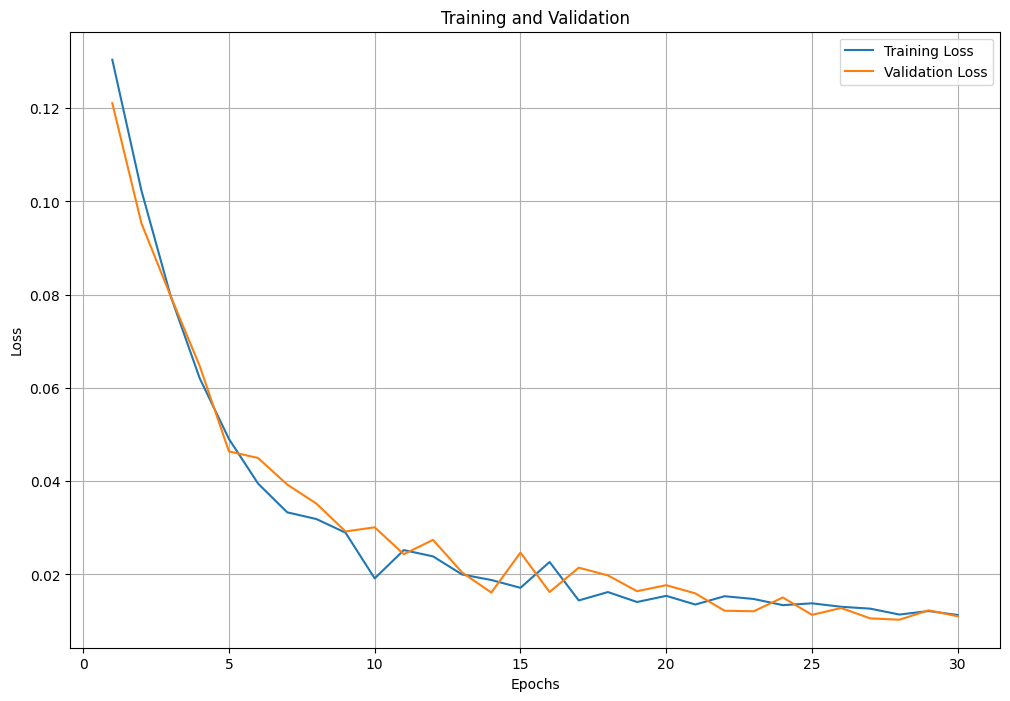

In [12]:
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import Autoencoder
import torch.nn as nn
import torch.optim as optim

#For logging
run = Configuration(model_name = 'Autoencoder')

#Instantiating model
model = Autoencoder()



# Defining Loss function and optimizer
Loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = run.config['learning_rate'], weight_decay = run.config['Weight_decay'])

latent,  val_latent, avg_loss_train, avg_loss_val, stop_epoch = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, stop_epoch)


In [13]:
encoder = latent.squeeze(0)
encoder_transpose = encoder.permute(2,1,0)
encoder = encoder_transpose.detach().numpy()
print(encoder.shape)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3